Lab Group 5: Sam and Raveel

# Lab Notebook 19

Today, we develop a fully connected neural network to solve a previously seen problem, the particle ID classification.

Based on: *Copyright: Viviana Acquaviva (2023). License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)*

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-03-20 01:06:50.510711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Part 1: 4top vs ttbar with neural nets

## Step 1.1

In [2]:
import tensorflow as tf
import keras

from keras.models import Sequential #the model is built adding layers one after the other
from keras.layers import Dense #fully connected layers: every output talks to every input
from keras.layers import Dropout #for regularization

We begin with the 4top vs ttbar problem, and we use the configuration where we added the features "number of leptons", "number of jets" etc. For reference, the optimal SVM achieved 94-95% accuracy. Note that those numbers had not been run through <b> nested </b> cross validation so they might be slightly optimistic. 

Read 'Features_lim_2.csv' in to a dataframe, and read 'Labels_lim_2.txt' into an array. You may find it helpful to look at the shape, elements, etc. of the data.

In [3]:
features = pd.read_csv('Features_lim_2.csv')

print(features.shape)
print(features.head)

labels = pd.read_csv('Labels_lim_2.txt', header=None)
print(labels.shape)
features.head

(0, 1)
<bound method NDFrame.head of Empty DataFrame
Columns: [Unauthorized]
Index: []>
(1, 1)


<bound method NDFrame.head of Empty DataFrame
Columns: [Unauthorized]
Index: []>

In [4]:
features = features.drop(['ID'],axis = 1)
features.columns

Index(['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'Total_products',
       'Total_b', 'Total_j', 'Total_g', 'Total_leptons'],
      dtype='object')

## Step 1.2

There is no "built-in" cross validation process here, so we would need to build it ourselves. For now, we can build three sets: train, validation (for parameter optimization), and test (for final evaluation). We should ideally build this as a cross-validation structure.

Use "shuffle" from sklearn to shuffle X and y, specifying a random state of 10. Let X_train be the first 3000 values, let X_val be the next 1000 values, and let X_test be the remaining values. Create y_train, y_val, and y_test in like manner. Print the shape of all arrays.

In [5]:
# features = shuffle(features, random_state=10)

# labels = shuffle(labels, random_state=10)

features, labels = shuffle(features, labels, random_state=10)

X_train = features[0:3000]
X_val = features[3000:4000]
X_test = features[4000:]

y_train = labels[0:3000]
y_val = labels[3000:4000]
y_test = labels[4000:]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(3000, 23)
(3000, 1)
(1000, 23)
(1000, 1)
(1000, 23)
(1000, 1)


## Step 1.3

Let's think about the model architecture.

1. Our input layer has **24 neurons**. 

2. Our output layer has **1 neuron** (the output is the probability that the object belongs to the positive class). We could also set it up as 2 neurons (and have softmax as the final non-linearity), but this is redundant in a binary classification problem.

3. We will add one hidden layer. Here we are making **size = 20** (we should optimize this hyperparameter!). We can also reserve the possibility of adding a dropout layer after each one. The dropout fraction should also be optimized through CV.

Other decisions that we have to make are: which nonlinearities we use (for now: ReLU for hidden layers, sigmoid for the final one), which optimizer we use (Adam), which starting learning rate we adopt (here 0.001, but again this should be decided through CV), the number of epochs (e.g. 100; we can plot quantities of interest to check that we have enough), the batch size for the gradient descent step (here 200, but can explore!) and the loss function. The latter is the binary cross entropy, which is the standard choice for classification problems where we output a probability. It rewards "confidence" in a correct prediction (high probability). 

Use the "dir" command to print the possible choices of optimizers in keras. Also, print the possible losses in keras.

In [6]:

print(dir(keras.optimizers))

['Adadelta', 'Adafactor', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'Ftrl', 'Lion', 'LossScaleOptimizer', 'Nadam', 'Optimizer', 'RMSprop', 'SGD', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'deserialize', 'get', 'legacy', 'schedules', 'serialize']


In [7]:

print(dir(keras.losses))

['BinaryCrossentropy', 'BinaryFocalCrossentropy', 'CTC', 'CategoricalCrossentropy', 'CategoricalFocalCrossentropy', 'CategoricalHinge', 'CosineSimilarity', 'Hinge', 'Huber', 'KLDivergence', 'LogCosh', 'Loss', 'MeanAbsoluteError', 'MeanAbsolutePercentageError', 'MeanSquaredError', 'MeanSquaredLogarithmicError', 'Poisson', 'SparseCategoricalCrossentropy', 'SquaredHinge', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'binary_crossentropy', 'binary_focal_crossentropy', 'categorical_crossentropy', 'categorical_focal_crossentropy', 'categorical_hinge', 'cosine_similarity', 'ctc', 'deserialize', 'get', 'hinge', 'huber', 'kl_divergence', 'log_cosh', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_error', 'mean_squared_logarithmic_error', 'poisson', 'serialize', 'sparse_categorical_crossentropy', 'squared_hinge']


A standard choice for a case like ours, where the labels are 0/1 but we can predict a probability, is the binary cross-entropy or log loss:

L = - $\frac{1}{N} \sum_{i=1}^N y_i \cdot log(p(y_i)) + (1-y_i) \cdot log (1 - p(y_i))$

p is the probability that an object belongs to the positive class. It penalizes positive examples that are associated with predicted low probability, and negative examples that are associated with predicted high probability.

Finally, print the list of the available activation functions from keras:

In [8]:
print(dir(keras.activations))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'deserialize', 'elu', 'exponential', 'gelu', 'get', 'hard_sigmoid', 'hard_silu', 'hard_swish', 'leaky_relu', 'linear', 'log_softmax', 'mish', 'relu', 'relu6', 'selu', 'serialize', 'sigmoid', 'silu', 'softmax', 'softplus', 'softsign', 'swish', 'tanh']


## Step 1.4

Given the architecture above, build this sequential neural net with keras. You can model the setup on last week's lab. Note that here you don't need to flatten the input (it is already flat), so the input layer should just be another dense layer with the correct input shape. You can either define the whole network (as in lab 18) or define **model = Sequential()** and then use the **model.add()** method to add layers.

*Note: The "metric" keyword here serves to specify other possible metrics we would like to monitor. The loss itself is not interpretable, so we'll keep an eye on the accuracy.*

In [9]:
model = keras.Sequential([
    keras.layers.Dense(24, activation='relu', input_shape=(23,)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/Users/samyoung/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Next, we'll move on to the fitting procedure. Define your neural network as the output of "model.fit" on your training data. Add the validation data as well, and set epochs=100 and batch_size=200.

*Note:* 
1. *"epochs" is the number of back-and-forth passages through the network.*
2. *"batch size" is how many of the data are used at every step in updating weights.*

In [10]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=200,
                    validation_data=(X_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7555 - loss: 17736.3535 - val_accuracy: 0.7540 - val_loss: 8371.5273
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7033 - loss: 7058.9971 - val_accuracy: 0.6850 - val_loss: 4318.7588
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.6673 - loss: 5108.7061 - val_accuracy: 0.7340 - val_loss: 3288.2004
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6933 - loss: 3784.7927 - val_accuracy: 0.7060 - val_loss: 2672.1316
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.6744 - loss: 2796.9148 - val_accuracy: 0.7060 - val_loss: 2219.1035
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6878 - loss: 2121.9529 - val_accuracy: 0.6460 - val_loss: 1980.3372
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.6935 - loss: 1757.7057 - val_accuracy: 0.6810 - val_loss: 1627.3483
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accurac

How does the training and validation look?

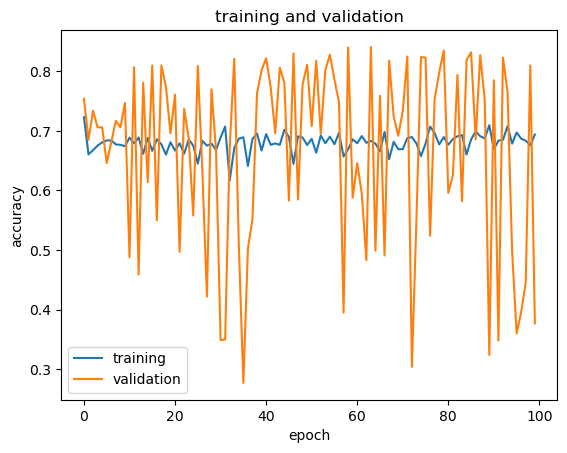

In [11]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('training and validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Step 1.5

It's helpful to plot how training and validation vary throughout the epochs.

First, plot the loss as a function of epoch for the training and validation data sets. Next, plot the accuracy as a function of epoch for the training and validation data sets. We already did this for the MNIST dataset example in the previous lab.

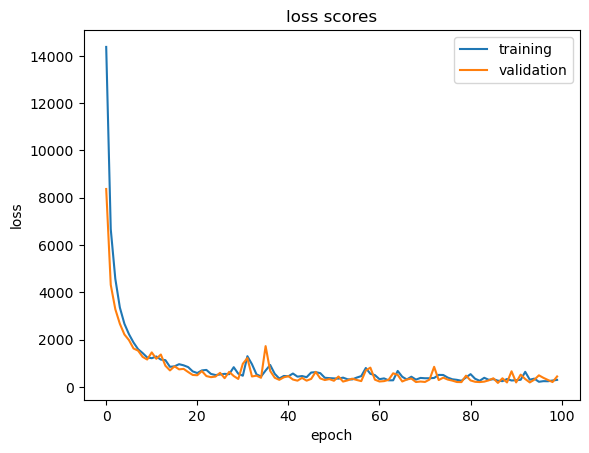

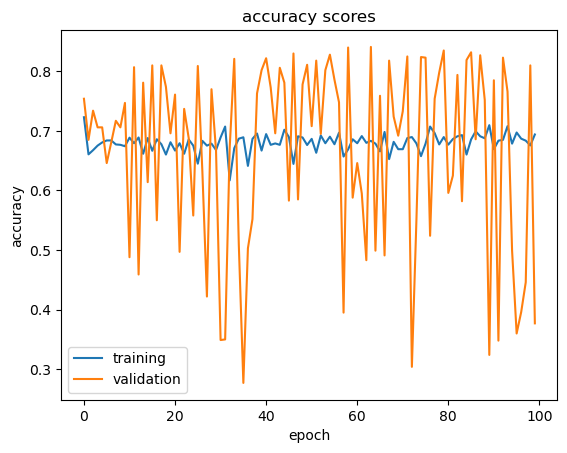

In [12]:
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss scores')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy scores')
plt.legend()
plt.show()

We can see how plotting the accuracy, which is interpetable, is more useful than plotting the loss. The wild oscillations observed in the validation, as well as the absolute value of the loss after 100 training epochs, are not great signs. 

How can we fix this?

Let's look at the data again using X.describe : 

In [13]:
features.describe

<bound method NDFrame.describe of             MET    METphi        P1        P2        P3        P4        P5  \
245    72289.90  3.007210  100564.0   79887.8 -0.698355  0.359872  120091.0   
4493  137156.00  1.590230  257374.0  163455.0  1.023240 -2.202930  331636.0   
4583    9127.87  1.133720  179905.0  127826.0 -0.863384 -1.421930  125872.0   
2242    7579.14  1.563310  984867.0  157734.0  2.517760 -3.013750   81143.9   
3407   92420.50  2.422940  465836.0  201899.0  1.477870 -0.114453  141499.0   
...         ...       ...       ...       ...       ...       ...       ...   
1180   63108.00  1.050140   89105.5   76583.0 -0.557376  2.889510  211469.0   
3441   27361.60  1.640940  158052.0   91134.6 -1.142850  0.813393   75570.6   
1344   27510.30 -1.198740  276888.0  110808.0 -1.563610  0.971738  468818.0   
4623   59647.40  0.372759  273236.0  152649.0 -1.185020 -0.390027  179878.0   
1289   35387.00  0.230285  161926.0   94276.8  1.128150 -2.667560   79160.5   

            P6   

## Step 1.6

We forgot scaling (and our features have wildly different ranges)! Use StandardScaler as usual. Remember, we only use the training set to derive the scaling.

In [14]:
scaler = StandardScaler()

Xs_train = scaler.fit_transform(X_train)
Xs_val = scaler.transform(X_val)

Define new training, validation, and test arrays for X that have been scaled using "transform":

In [15]:
Xs_val = scaler.transform(X_val)
Xs_test = scaler.transform(X_test)


We can now train our neural network again. As before, use "model.fit", but this time with the new X arrays:

In [16]:
history_scaled = model.fit(Xs_train, y_train,
                            epochs=100,
                            batch_size=200,
                            validation_data=(Xs_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8375 - loss: 0.7006 - val_accuracy: 0.8470 - val_loss: 0.6391
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.8358 - loss: 0.6641 - val_accuracy: 0.8470 - val_loss: 0.5460
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.8411 - loss: 0.5061 - val_accuracy: 0.8520 - val_loss: 0.4023
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.8567 - loss: 0.3498 - val_accuracy: 0.8670 - val_loss: 0.2828
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.9021 - loss: 0.2369 - val_accuracy: 0.8970 - val_loss: 0.2250
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.9168 - loss: 0.1955 - val_accuracy: 0.9110 - val_loss: 0.1982
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.9288 - loss: 0.1799 - val_accuracy: 0.9220 - val_loss: 0.1831
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.9304 - loss: 0.1626 - val_accura

The accuracies should look much better now! Make the two plots from Step 5 below, now with your new results:

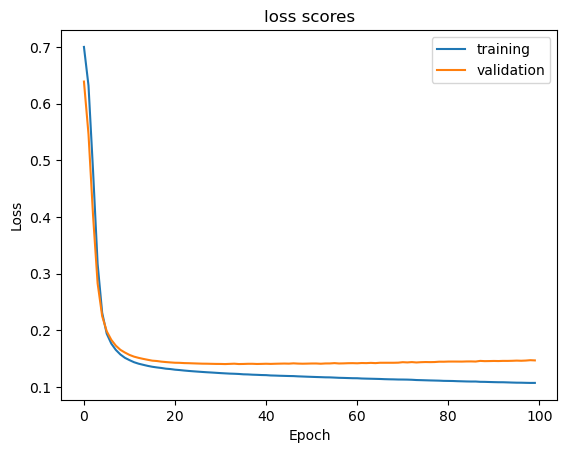

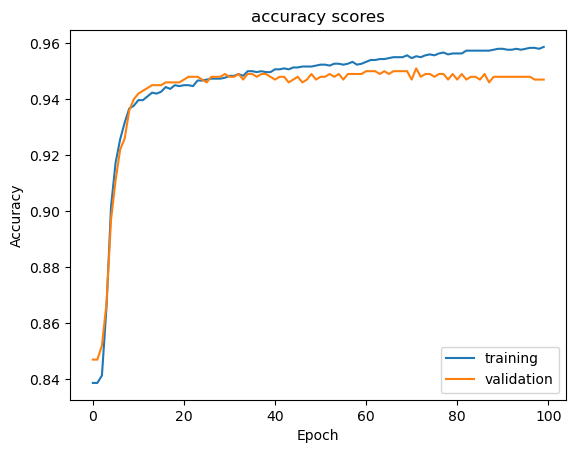

In [17]:
plt.plot(history_scaled.history['loss'],label='training')
plt.plot(history_scaled.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("loss scores")
plt.legend()
plt.show()

plt.plot(history_scaled.history['accuracy'],label='training')
plt.plot(history_scaled.history['val_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy scores')
plt.legend()
plt.show()

As you can see, this network is much better behaved, and it achieves a final accuracy similar to the one found by SVMs (this is common for tabular data like ours). We do see some signs of high variance in the accuracy/validation curve; some regularization technique, may help.

## Step 1.7

The final evaluation of the model is always done on the test set; the reason is that the validation fold is used for hyperparameter optimization (which we haven't done here), and test set is blind to it.

Define "scores" as the output of "model.evaluate", and specify "verbose=1". Print the accuracy.

In [18]:
scores = model.evaluate(Xs_test, y_test, verbose=1)
print("accuracy: {}".format(scores[1]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - accuracy: 0.9436 - loss: 0.1914
accuracy: 0.9459999799728394


# Part 2: Regularization

There are several options for regularization; here we explore a few. 

First, add a **dropout layer** via the command

model.add(Dropout(0.2)) #This is the dropout fraction

after both first and hidden layer. Then train this model and store the training history for later plotting.

In [19]:
model_dropout = Sequential([
    Dense(24, activation='relu', input_shape=(23,)),
    Dropout(0.2),
    Dense(20, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_dropout.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/Users/samyoung/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
history_dropout = model_dropout.fit(Xs_train, y_train,
                                    epochs=100,
                                    batch_size=200,
                                    validation_data=(Xs_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5479 - loss: 0.7105 - val_accuracy: 0.8360 - val_loss: 0.5041
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.7661 - loss: 0.5271 - val_accuracy: 0.8880 - val_loss: 0.3990
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8648 - loss: 0.4242 - val_accuracy: 0.9010 - val_loss: 0.3324
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8587 - loss: 0.3825 - val_accuracy: 0.9080 - val_loss: 0.2843
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8939 - loss: 0.3140 - val_accuracy: 0.9120 - val_loss: 0.2475
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.8907 - loss: 0.2997 - val_accuracy: 0.9200 - val_loss: 0.2193
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.9127 - loss: 0.2536 - val_accuracy: 0.9250 - val_loss: 0.1990
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.9068 - loss: 0.2391 - val_accuracy: 0.

Now lets remove the dropout layers and instead add an **L2-norm penalty** to the weights, similar to what is done in linear regression. You can do this via the

kernel_regularizer=keras.regularizers.l2(0.001)

parameter in model.add(). Train this model and save the training history.

In [21]:
from keras import regularizers

model_l2 = Sequential([
    Dense(24, activation='relu', input_shape=(23,), kernel_regularizer=keras.regularizers.l2(0.001)),
    Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])
model_l2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history_l2 = model_l2.fit(Xs_train, y_train,
                          epochs=100,
                          batch_size=200,
                          validation_data=(Xs_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6009 - loss: 0.7571 - val_accuracy: 0.7850 - val_loss: 0.6290
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.8077 - loss: 0.6179 - val_accuracy: 0.8560 - val_loss: 0.5238
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.8461 - loss: 0.5157 - val_accuracy: 0.8760 - val_loss: 0.4364
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.8810 - loss: 0.4268 - val_accuracy: 0.8930 - val_loss: 0.3629
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.9053 - loss: 0.3491 - val_accuracy: 0.9120 - val_loss: 0.3080
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.9157 - loss: 0.3013 - val_accuracy: 0.9220 - val_loss: 0.2712
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.9288 - loss: 0.2589 - val_accuracy: 0.9270 - val_loss: 0.2473
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.9319 - loss: 0.2352 - val_accura

Now let's generate comparison plots of losses and accuracy for the three models (regular, dropout, L2) combined for ease of comparison.

Text(0.5, 1.0, 'accuracy scores L2')

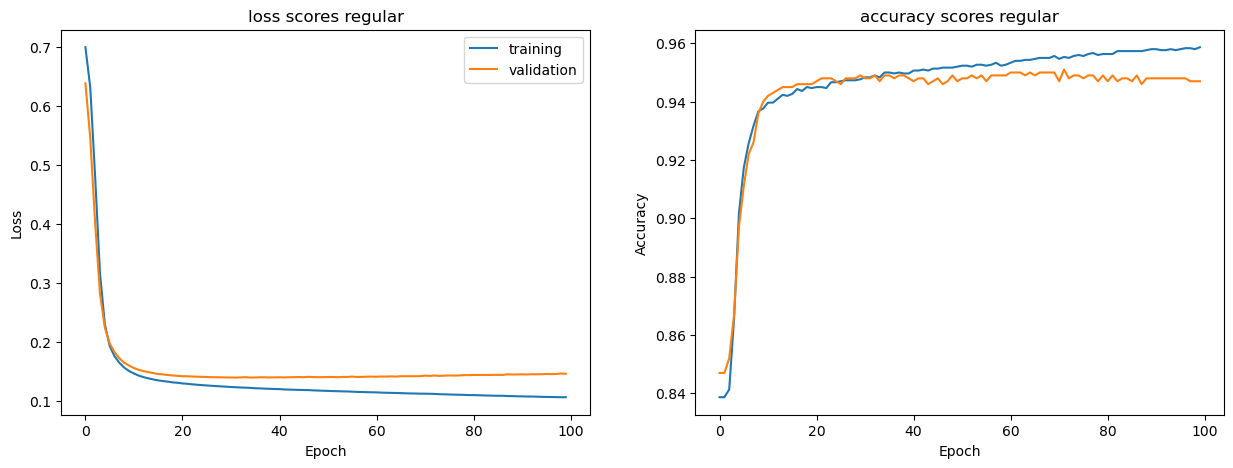

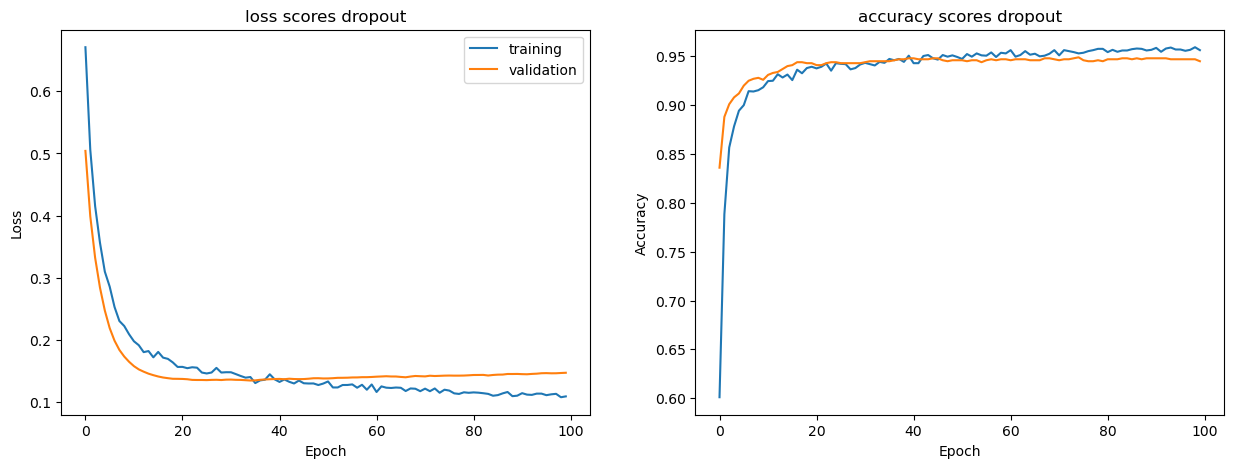

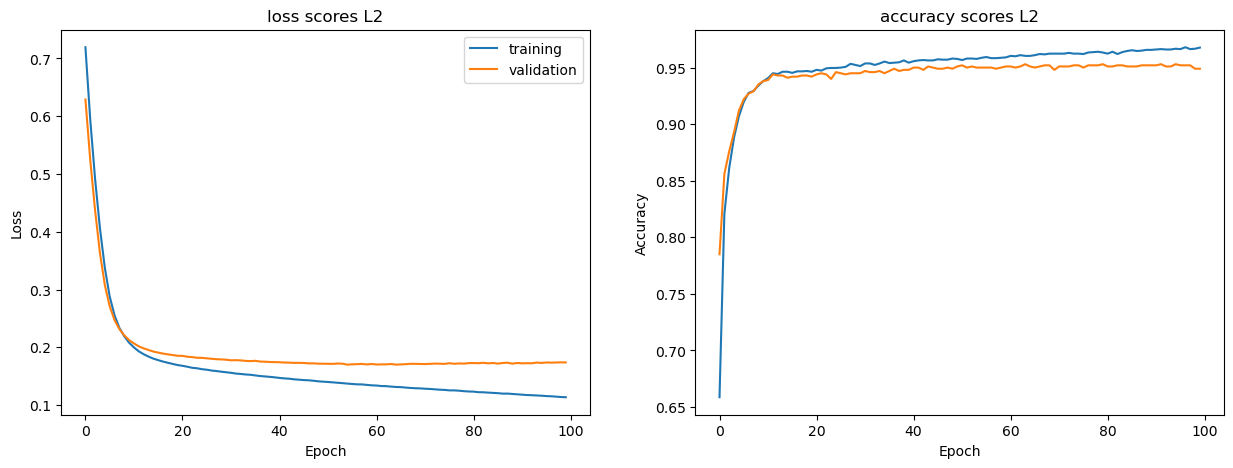

In [35]:
# Regular
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_scaled.history['loss'],label='training')
plt.plot(history_scaled.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("loss scores regular")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_scaled.history['accuracy'],label='training')
plt.plot(history_scaled.history['val_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy scores regular')

# Drop out
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dropout.history['loss'],label='training')
plt.plot(history_dropout.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("loss scores dropout")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dropout.history['accuracy'],label='training')
plt.plot(history_dropout.history['val_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy scores dropout')


# L2
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_l2.history['loss'],label='training')
plt.plot(history_l2.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("loss scores L2")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_l2.history['accuracy'],label='training')
plt.plot(history_l2.history['val_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy scores L2')

# Part 3: Study of Optimizers

The performance of the NN is can also be strongly affected by the choice of optimizers. Let's train five different models with five different optimizers:

1) SGD (stochastic gradient descent, default parameters)
2) Momentum (= SGD with momentum=0.5)
3) RMSprop
4) Adagrad
5) Adam

Note that for SGD the default learning rate is set to 0.01, while it is 0.001 for the other ones.

Train the five different models and store the training history. After that, make a plot of the training vs history for these five optimizers. Then make the same plot again for the validation. Which optimizer is best?

In [24]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adam

In [25]:
#SGD
model_sgd = keras.Sequential([
    Dense(24, activation='relu', input_shape=(23,)),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_sgd.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

history_sgd = model_sgd.fit(Xs_train, y_train,
                                    epochs=100,
                                    batch_size=200,
                                    validation_data=(Xs_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5993 - loss: 0.7267 - val_accuracy: 0.7240 - val_loss: 0.6468
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.7380 - loss: 0.6549 - val_accuracy: 0.8080 - val_loss: 0.5868
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7972 - loss: 0.6004 - val_accuracy: 0.8350 - val_loss: 0.5385
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.8203 - loss: 0.5464 - val_accuracy: 0.8490 - val_loss: 0.4985
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.8283 - loss: 0.5057 - val_accuracy: 0.8530 - val_loss: 0.4647
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.8403 - loss: 0.4723 - val_accuracy: 0.8580 - val_loss: 0.4356
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.8492 - loss: 0.4362 - val_accuracy: 0.8620 - val_loss: 0.4102
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.8507 - loss: 0.4148 - val_accura

Text(0.5, 1.0, 'accuracy scores SGD')

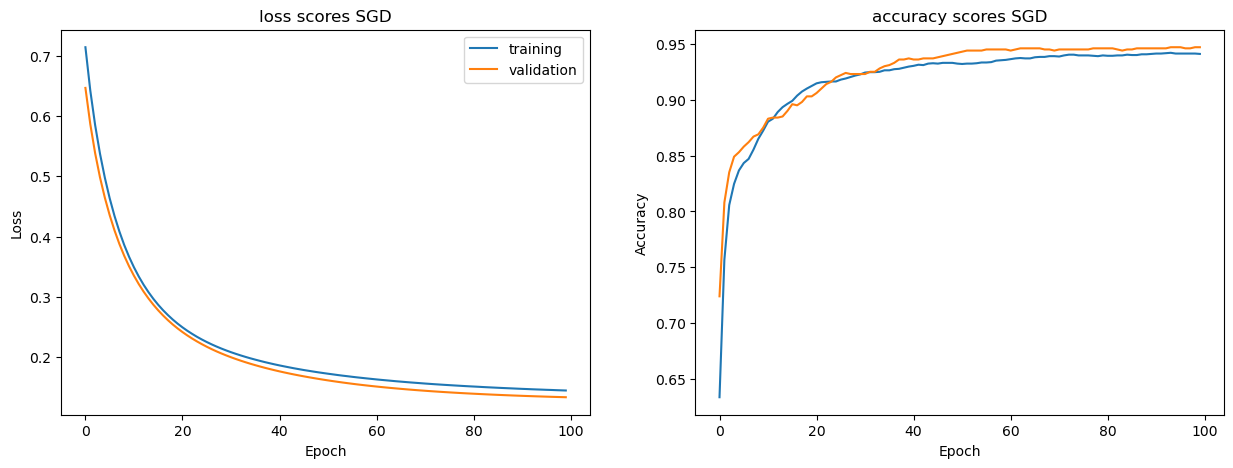

In [39]:

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_sgd.history['loss'],label='training')
plt.plot(history_sgd.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("loss scores SGD")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_sgd.history['accuracy'],label='training')
plt.plot(history_sgd.history['val_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy scores SGD')

In [27]:
#Momentum
model_mom = keras.Sequential([
    Dense(24, activation='relu', input_shape=(23,)),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_mom.compile(optimizer=SGD(momentum=0.5), loss='binary_crossentropy', metrics=['accuracy'])

history_mom = model_mom.fit(Xs_train, y_train,
                                    epochs=100,
                                    batch_size=200,
                                    validation_data=(Xs_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6873 - loss: 0.6296 - val_accuracy: 0.8120 - val_loss: 0.5233
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.8304 - loss: 0.5033 - val_accuracy: 0.8510 - val_loss: 0.4416
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.8486 - loss: 0.4361 - val_accuracy: 0.8640 - val_loss: 0.3884
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.8532 - loss: 0.3867 - val_accuracy: 0.8680 - val_loss: 0.3502
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.8568 - loss: 0.3562 - val_accuracy: 0.8750 - val_loss: 0.3213
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.8733 - loss: 0.3201 - val_accuracy: 0.8800 - val_loss: 0.2983
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.8835 - loss: 0.2882 - val_accuracy: 0.8900 - val_loss: 0.2793
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.8865 - loss: 0.2827 - val_accura

Text(0.5, 1.0, 'accuracy scores momentum')

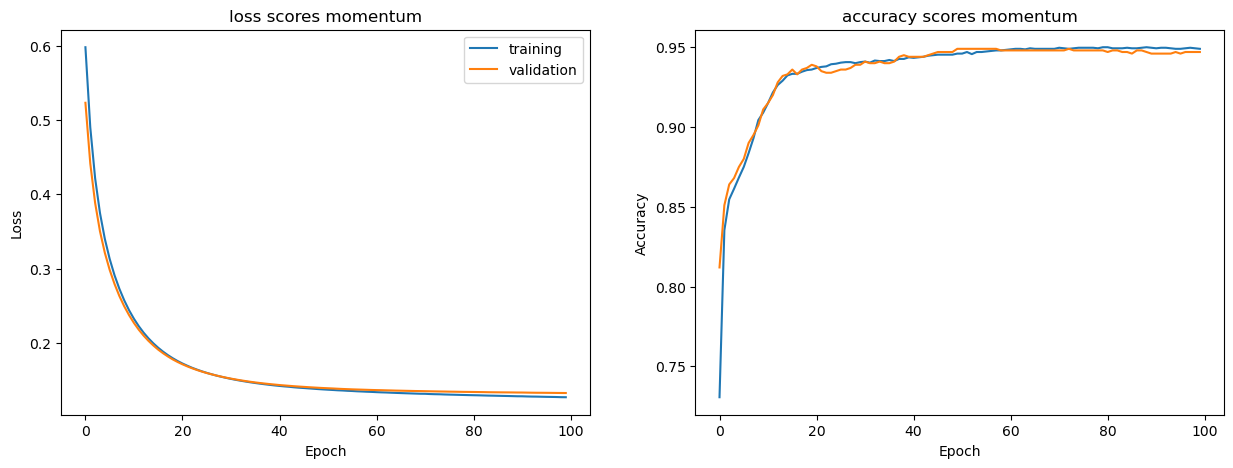

In [36]:

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mom.history['loss'],label='training')
plt.plot(history_mom.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("loss scores momentum")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mom.history['accuracy'],label='training')
plt.plot(history_mom.history['val_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy scores momentum')

In [29]:
#RMSprop
model_rms = keras.Sequential([
    Dense(24, activation='relu', input_shape=(23,)),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_rms.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

history_rms = model_rms.fit(Xs_train, y_train,
                                    epochs=100,
                                    batch_size=200,
                                    validation_data=(Xs_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4855 - loss: 0.7022 - val_accuracy: 0.7920 - val_loss: 0.5497
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.8185 - loss: 0.5157 - val_accuracy: 0.8760 - val_loss: 0.4439
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.8750 - loss: 0.4209 - val_accuracy: 0.8900 - val_loss: 0.3654
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.9039 - loss: 0.3500 - val_accuracy: 0.9050 - val_loss: 0.3055
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.9207 - loss: 0.2846 - val_accuracy: 0.9120 - val_loss: 0.2585
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.9125 - loss: 0.2543 - val_accuracy: 0.9180 - val_loss: 0.2243
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.9321 - loss: 0.2080 - val_accuracy: 0.9270 - val_loss: 0.2000
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9327 - loss: 0.1885 - val_accura

Text(0.5, 1.0, 'accuracy scores RMS')

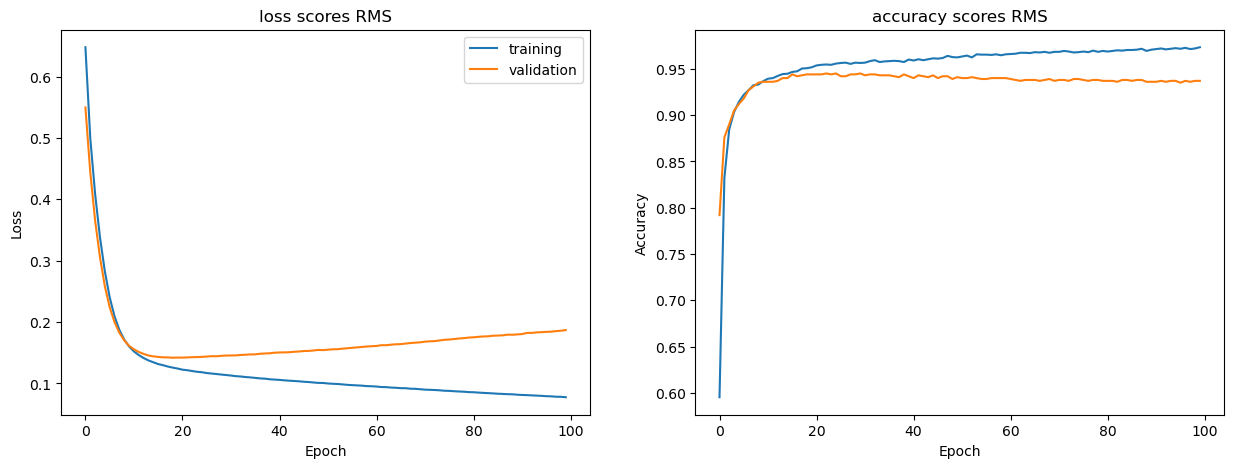

In [37]:

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rms.history['loss'],label='training')
plt.plot(history_rms.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("loss scores RMS")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rms.history['accuracy'],label='training')
plt.plot(history_rms.history['val_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy scores RMS')

In [31]:
#Adagrad
model_ada = keras.Sequential([
    Dense(24, activation='relu', input_shape=(23,)),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_ada.compile(optimizer=Adagrad(), loss='binary_crossentropy', metrics=['accuracy'])

history_ada = model_ada.fit(Xs_train, y_train,
                                    epochs=100,
                                    batch_size=200,
                                    validation_data=(Xs_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7256 - loss: 0.6377 - val_accuracy: 0.7580 - val_loss: 0.6011
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.7480 - loss: 0.6252 - val_accuracy: 0.7790 - val_loss: 0.5876
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.7736 - loss: 0.6051 - val_accuracy: 0.7970 - val_loss: 0.5759
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.7936 - loss: 0.5959 - val_accuracy: 0.8080 - val_loss: 0.5655
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.8007 - loss: 0.5853 - val_accuracy: 0.8150 - val_loss: 0.5560
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.8094 - loss: 0.5795 - val_accuracy: 0.8240 - val_loss: 0.5473
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.8220 - loss: 0.5633 - val_accuracy: 0.8290 - val_loss: 0.5392
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.8179 - loss: 0.5572 - val_accura

Text(0.5, 1.0, 'Accuracy Scores Adagrad')

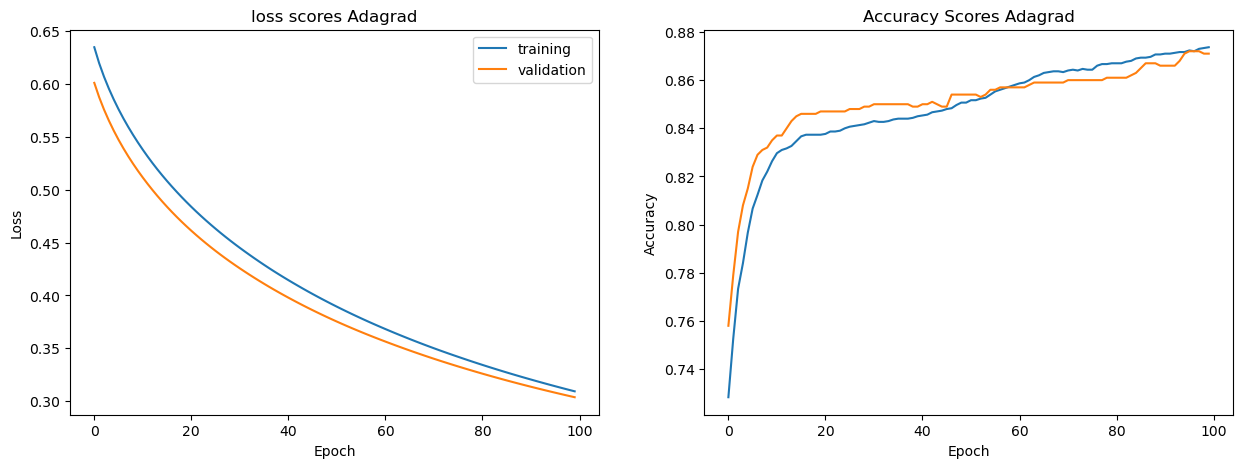

In [32]:

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ada.history['loss'],label='training')
plt.plot(history_ada.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("loss scores adagrad")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ada.history['accuracy'],label='training')
plt.plot(history_ada.history['val_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy scores Adagrad')

In [33]:
#Adam
model_adam = keras.Sequential([
    Dense(24, activation='relu', input_shape=(23,)),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_adam.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history_adam = model_adam.fit(Xs_train, y_train,
                                    epochs=100,
                                    batch_size=200,
                                    validation_data=(Xs_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6543 - loss: 0.6263 - val_accuracy: 0.8270 - val_loss: 0.4880
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8266 - loss: 0.4723 - val_accuracy: 0.8500 - val_loss: 0.3911
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8509 - loss: 0.3833 - val_accuracy: 0.8760 - val_loss: 0.3276
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8744 - loss: 0.3183 - val_accuracy: 0.8900 - val_loss: 0.2795
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8898 - loss: 0.2717 - val_accuracy: 0.9060 - val_loss: 0.2436
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9090 - loss: 0.2388 - val_accuracy: 0.9230 - val_loss: 0.2172
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.9258 - loss: 0.1983 - val_accuracy: 0.9270 - val_loss: 0.1984
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.9287 - loss: 0.1893 - val_accuracy: 0.9350

Text(0.5, 1.0, 'accuracy scores adam')

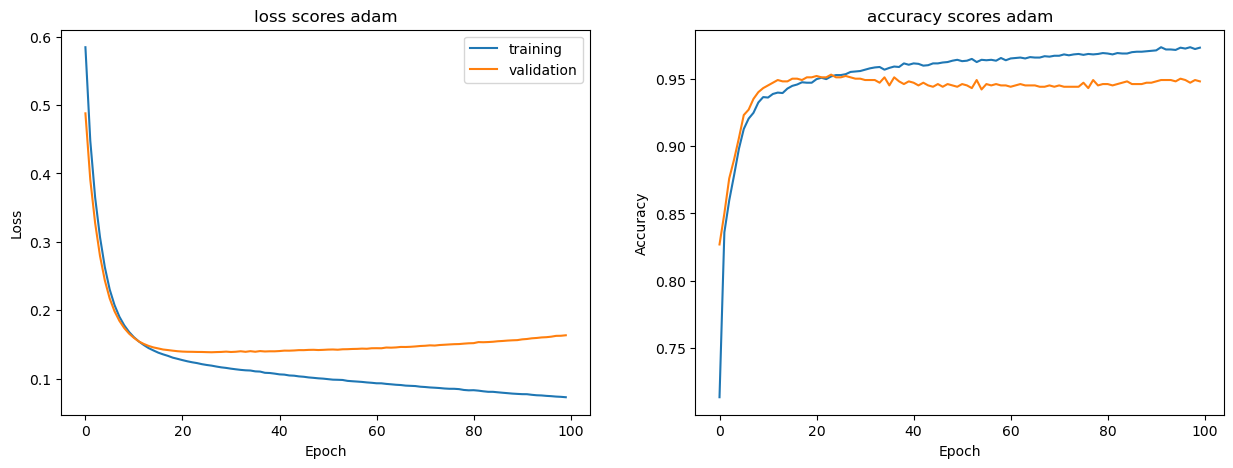

In [38]:

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_adam.history['loss'],label='training')
plt.plot(history_adam.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("loss scores adam")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_adam.history['accuracy'],label='training')
plt.plot(history_adam.history['val_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy scores adam')

<b>Adam and RMS look to be best